<a href="https://colab.research.google.com/github/vaylerie/starfish-classification/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import MobileNet
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.backend import clear_session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set directory paths
image_dir = '/content/drive/MyDrive/ProjectSiscerBintangLaut/Dataset'

# Load data into DataFrame
filename = []
label = []
# Iterate through each directory in image_dir
for dir_name in os.listdir(image_dir):
    # Iterate through each file in the directory
    for file in os.listdir(os.path.join(image_dir, dir_name)):
        # Append file path and label to lists
        filename.append(os.path.join(dir_name, file))
        label.append(dir_name)

In [ ]:
# Check total data
print(len(filename))

200


In [ ]:
# Create a DataFrame to hold the file paths and labels
data = {"filename": filename, "label": label}
df = pd.DataFrame(data)
print(df)

                          filename                 label
0       Linckia Laevigata/LL34.png     Linckia Laevigata
1       Linckia Laevigata/LL46.png     Linckia Laevigata
2       Linckia Laevigata/LL31.png     Linckia Laevigata
3       Linckia Laevigata/LL38.png     Linckia Laevigata
4       Linckia Laevigata/LL21.png     Linckia Laevigata
..                             ...                   ...
195  Protoreaster Nodosus/PN16.png  Protoreaster Nodosus
196   Protoreaster Nodosus/PN4.png  Protoreaster Nodosus
197   Protoreaster Nodosus/PN3.png  Protoreaster Nodosus
198  Protoreaster Nodosus/PN17.png  Protoreaster Nodosus
199  Protoreaster Nodosus/PN12.png  Protoreaster Nodosus

[200 rows x 2 columns]


In [ ]:
# Shuffle the DataFrame
df_shuffled = df.sample(frac=1).reset_index(drop=True)
print(df_shuffled)

                          filename                 label
0       Linckia Laevigata/LL34.png     Linckia Laevigata
1     Culcita Novaguineae/CN35.png   Culcita Novaguineae
2     Culcita Novaguineae/CN36.png   Culcita Novaguineae
3     Protoreaster Nodosus/PN5.png  Protoreaster Nodosus
4        Luidia Foliolata/LF24.png      Luidia Foliolata
..                             ...                   ...
195   Protoreaster Nodosus/PN2.png  Protoreaster Nodosus
196  Protoreaster Nodosus/PN43.png  Protoreaster Nodosus
197     Linckia Laevigata/LL26.png     Linckia Laevigata
198      Luidia Foliolata/LF49.png      Luidia Foliolata
199   Culcita Novaguineae/CN32.png   Culcita Novaguineae

[200 rows x 2 columns]


In [ ]:
# Split data into training, validation, and testing sets (75% training, 20% validation, 5% testing)
train_df, test_df = train_test_split(df_shuffled, test_size=0.05, stratify=df_shuffled['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.21, stratify=train_df['label'], random_state=42)  # 0.2 * 0.75 = 0.15

print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Testing set: {len(test_df)}")

Training set: 150
Validation set: 40
Testing set: 10


In [ ]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and testing data
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Prepare data generators
train_data_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",
    shuffle=True
)

val_data_generator = test_datagen.flow_from_dataframe(
    val_df,
    directory=image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",
    shuffle=False
)

test_data_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",
    shuffle=False
)

Found 150 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.
Found 10 validated image filenames belonging to 4 classes.


In [ ]:
# Define the model
def build_model():
    # Load pre-trained MobileNet model without top layer
    pretrained_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    # Freeze all layers in the pre-trained model
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = GlobalAveragePooling2D()(pretrained_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)  # Assuming there are 4 classes
    model = Model(pretrained_model.input, output)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Cross-validation and training
kf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

# Lists to store evaluation metrics
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_F1SCORE = []

LOSS = []
ACCURACY = []

VAL_LOSS = []
VAL_ACCURACY = []

# Containers for per-fold scores
acc_per_fold = []
loss_per_fold = []

# Variable for fold iteration
fold_var = 1
Y = train_df[['label']]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 120 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.


Training for fold 1 ...
Epoch 1/10
 9/15 [=================>............] - ETA: 6s - loss: 1.4070 - accuracy: 0.4722

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 33s 2s/step - loss: 1.0885 - accuracy: 0.5667 - val_loss: 0.2039 - val_accuracy: 0.9333
Epoch 2/10
15/15 [==============================] - 7s 447ms/step - loss: 0.3022 - accuracy: 0.8500 - val_loss: 0.0834 - val_accuracy: 1.0000
Epoch 3/10
15/15 [==============================] - 7s 489ms/step - loss: 0.1429 - accuracy: 0.9417 - val_loss: 0.0636 - val_accuracy: 0.9667
Epoch 4/10
15/15 [==============================] - 9s 603ms/step - loss: 0.1088 - accuracy: 0.9417 - val_loss: 0.0742 - val_accuracy: 0.9667
Epoch 5/10
15/15 [==============================] - 6s 421ms/step - loss: 0.0343 - accuracy: 0.9917 - val_loss: 0.0227 - val_accuracy: 1.0000
Epoch 6/10
15/15 [==============================] - 8s 466ms/step - loss: 0.0566 - accuracy: 0.9917 - val_loss: 0.0273 - val_accuracy: 0.9667
Epoch 7/10
15/15 [==============================] - 10s 694ms/step - loss: 0.0362 - accuracy: 0.9917 - val_loss: 0.0462 - val_accuracy: 0.9667
Epoch 8/10
15/15 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 1 saved.


4/4 [==============================] - 1s 219ms/step - loss: 0.0371 - accuracy: 0.9667
Score for fold 1: loss of 0.03705483302474022; accuracy of 96.66666388511658%
4/4 [==============================] - 2s 394ms/step


Cross Validation :  1
Accuracy :  0.9666666388511658
Precision :  0.9708333333333333
Recall :  0.9666666666666667
F1Score :  0.9666666666666667




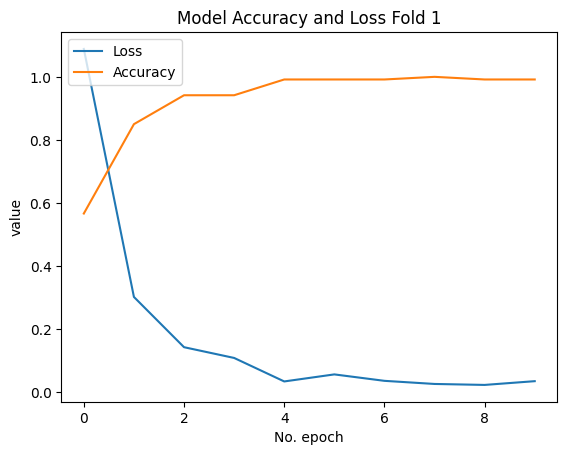

Found 120 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.


Training for fold 2 ...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
15/15 [==============================] - 10s 482ms/step - loss: 0.9831 - accuracy: 0.6667 - val_loss: 0.1546 - val_accuracy: 1.0000
Epoch 2/10
15/15 [==============================] - 9s 589ms/step - loss: 0.2489 - accuracy: 0.9000 - val_loss: 0.1262 - val_accuracy: 0.9333
Epoch 3/10
15/15 [==============================] - 7s 447ms/step - loss: 0.1636 - accuracy: 0.9750 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 4/10
15/15 [==============================] - 7s 439ms/step - loss: 0.0724 - accuracy: 0.9750 - val_loss: 0.0317 - val_accuracy: 1.0000
Epoch 5/10
15/15 [==============================] - 9s 605ms/step - loss: 0.0857 - accuracy: 0.9750 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 6/10
15/15 [==============================] - 7s 433ms/step - loss: 0.0354 - accuracy: 0.9917 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 7/10
15/15 [==============================] - 8s 480ms/step - loss: 0.0371 - accuracy: 0.9917 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 2 saved.


4/4 [==============================] - 1s 241ms/step - loss: 0.0043 - accuracy: 1.0000
Score for fold 2: loss of 0.004298212006688118; accuracy of 100.0%
4/4 [==============================] - 2s 253ms/step


Cross Validation :  2
Accuracy :  1.0
Precision :  1.0
Recall :  1.0
F1Score :  1.0




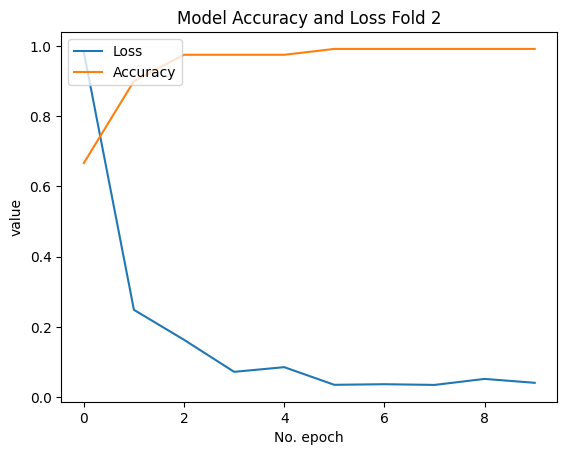

Found 120 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.


Training for fold 3 ...
Epoch 1/10
 2/15 [===>..........................] - ETA: 12s - loss: 1.5214 - accuracy: 0.5625 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 15s 758ms/step - loss: 0.8565 - accuracy: 0.6667 - val_loss: 0.2034 - val_accuracy: 0.9667
Epoch 2/10
15/15 [==============================] - 9s 605ms/step - loss: 0.2786 - accuracy: 0.8833 - val_loss: 0.1387 - val_accuracy: 0.9667
Epoch 3/10
11/15 [=====================>........] - ETA: 1s - loss: 0.1130 - accuracy: 0.9773

KeyboardInterrupt: 

In [ ]:
# Perform k-fold cross-validation
for train_index, val_index in kf.split(np.zeros(len(Y)), Y):
    training_data = train_df.iloc[train_index]
    validation_data = train_df.iloc[val_index]

    # Create data generators for training and validation
    train_data_generator = train_datagen.flow_from_dataframe(
        training_data,
        directory=image_dir,
        x_col="filename",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        class_mode="categorical",
        shuffle=True
    )

    valid_data_generator = test_datagen.flow_from_dataframe(
        validation_data,
        directory=image_dir,
        x_col="filename",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        class_mode="categorical",
        shuffle=False
    )

    print('\n')
    print(f'Training for fold {fold_var} ...')

    # Build and train the model
    model = build_model()
    hist = model.fit(
        train_data_generator,
        validation_data=valid_data_generator,
        epochs=10,
        steps_per_epoch=training_data.shape[0] // 8
    )

    # Save the model
    model.save(f"model_fold_{fold_var}.h5")
    print(f"Model for fold {fold_var} saved.")
    print('\n')

    # Evaluate the model on validation data
    results = model.evaluate(valid_data_generator)
    print(f'Score for fold {fold_var}: {model.metrics_names[0]} of {results[0]}; {model.metrics_names[1]} of {results[1] * 100}%')

    # Predict labels for validation data
    y_predict = model.predict(valid_data_generator)
    y = np.asarray(valid_data_generator.labels)
    y_predict_labels = np.argmax(y_predict, axis=1)

    # Calculate evaluation metrics
    acc = accuracy_score(y_predict_labels, y)
    prec = precision_score(y_predict_labels, y, average='weighted')
    rec = recall_score(y_predict_labels, y, average='weighted')
    f1score = f1_score(y_predict_labels, y, average='weighted')

    print("\n")
    print("Cross Validation : ", fold_var)
    print("Accuracy : ", results[1])
    print("Precision : ", prec)
    print("Recall : ", rec)
    print("F1Score : ", f1score)
    print("\n")

    # Plot training history
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(hist.history['accuracy'], label='Accuracy')
    plt.title(f'Model Accuracy and Loss Fold {fold_var}')
    plt.ylabel('value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

    # Append metrics to lists
    VALIDATION_ACCURACY.append(results[1])
    VALIDATION_PRECISION.append(prec)
    VALIDATION_RECALL.append(rec)
    VALIDATION_F1SCORE.append(f1score)

    LOSS.append(hist.history['loss'])
    ACCURACY.append(hist.history['accuracy'])

    VAL_LOSS.append(hist.history['val_loss'])
    VAL_ACCURACY.append(hist.history['val_accuracy'])

    acc_per_fold.append(results[1] * 100)
    loss_per_fold.append(results[0])
    fold_var += 1

In [ ]:
train_data = df_shuffled
Y = train_data[['label']]
kf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_F1SCORE = []

CV = []

LOSS = []
ACCURACY = []

VAL_LOSS = []
VAL_ACCURACY = []

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

In [ ]:
fold_var = 1

#Looping for each cross validation
for train_index, val_index in kf.split(np.zeros(len(Y)),Y):
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

  train_data_generator = train_datagen.flow_from_dataframe(training_data, directory=image_dir,
                                                           x_col="filename", y_col="label",
                                                           target_size=(224,224),batch_size=8,
                                                           class_mode="categorical", shuffle=True)
  valid_data_generator = test_datagen.flow_from_dataframe(validation_data, directory=image_dir,
                                                           x_col="filename", y_col="label",
                                                           target_size=(224,224),batch_size=8,
                                                           class_mode="categorical", shuffle=False)
  print('\n')

  pretrained_model = MobileNet(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')

  for layer in pretrained_model.layers:
    layer.trainable = False

Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.




Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
    

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 18s 727ms/step - loss: 0.6151 - accuracy: 0.7625 - val_loss: 0.1005 - val_accuracy: 0.9750
Epoch 2/10
20/20 [==============================] - 7s 333ms/step - loss: 0.2391 - accuracy: 0.9000 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 9s 431ms/step - loss: 0.0811 - accuracy: 0.9875 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 6s 322ms/step - loss: 0.0389 - accuracy: 0.9875 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 11s 567ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 7s 328ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 9s 435ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 8/10
20/2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model untuk fold 1 telah disimpan. 


5/5 [==============================] - 2s 294ms/step - loss: 0.0032 - accuracy: 1.0000
Score for fold 1: loss of 0.0032338860910385847; accuracy of 100.0%
5/5 [==============================] - 2s 241ms/step


Cross Validation :  1
Accuracy :  1.0
Precision :  1.0
Recall :  1.0
F1Score :  1.0




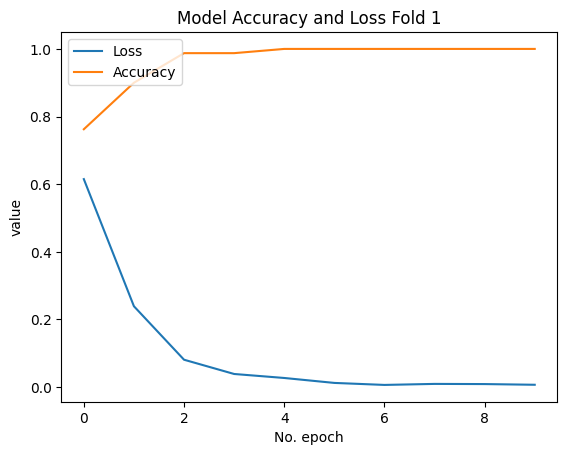



Confusion Matrix untuk fold  1
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


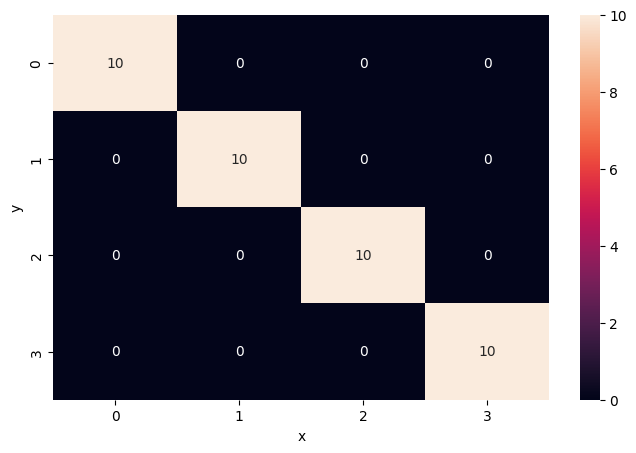

                      precision    recall  f1-score   support

 Culcita novaguineae       1.00      1.00      1.00        10
  Linckia laevigatai       1.00      1.00      1.00        10
    Luidia foliolata       1.00      1.00      1.00        10
Protoreaster nodosus       1.00      1.00      1.00        10

            accuracy                           1.00        40
           macro avg       1.00      1.00      1.00        40
        weighted avg       1.00      1.00      1.00        40

Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 11s 475ms/step - loss: 0.6872 - accuracy: 0.7250 - val_loss: 0.1743 - val_accuracy: 0.9250
Epoch 2/10
20/20 [==============================] - 7s 331ms/step - loss: 0.1682 - accuracy: 0.9625 - val_loss: 0.0690 - val_accuracy: 0.9750
Epoch 3/10
20/20 [==============================] - 9s 443ms/step - loss: 0.0793 - accuracy: 0.9688 - val_loss: 0.0521 - val_accuracy: 0.9750
Epoch 4/10
20/20 [==============================] - 7s 331ms/step - loss: 0.0351 - accuracy: 0.9875 - val_loss: 0.0535 - val_accuracy: 0.9750
Epoch 5/10
20/20 [==============================] - 9s 456ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0714 - val_accuracy: 0.9750
Epoch 6/10
20/20 [==============================] - 7s 330ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.0604 - val_accuracy: 0.9750
Epoch 7/10
20/20 [==============================] - 9s 447ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.1287 - val_accuracy: 0.9500
Epoch 8/10
20/20

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 2s 441ms/step - loss: 0.0724 - accuracy: 0.9750
Score for fold 2: loss of 0.07237502932548523; accuracy of 97.50000238418579%
5/5 [==============================] - 3s 435ms/step


Cross Validation :  2
Accuracy :  0.9750000238418579
Precision :  0.9775
Recall :  0.975
F1Score :  0.975062656641604




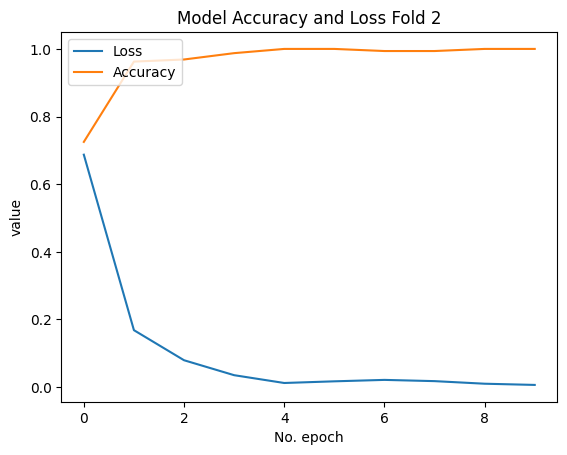



Confusion Matrix untuk fold  2
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  1  9  0]
 [ 0  0  0 10]]


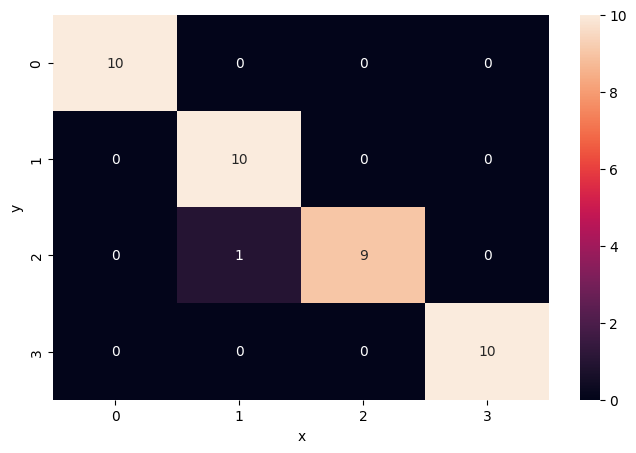

                      precision    recall  f1-score   support

 Culcita novaguineae       1.00      1.00      1.00        10
  Linckia laevigatai       0.91      1.00      0.95        10
    Luidia foliolata       1.00      0.90      0.95        10
Protoreaster nodosus       1.00      1.00      1.00        10

            accuracy                           0.97        40
           macro avg       0.98      0.97      0.97        40
        weighted avg       0.98      0.97      0.97        40

Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 12s 492ms/step - loss: 0.7000 - accuracy: 0.7437 - val_loss: 0.1404 - val_accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 7s 351ms/step - loss: 0.1308 - accuracy: 0.9688 - val_loss: 0.0764 - val_accuracy: 0.9750
Epoch 3/10
20/20 [==============================] - 9s 473ms/step - loss: 0.0671 - accuracy: 0.9688 - val_loss: 0.1010 - val_accuracy: 0.9250
Epoch 4/10
20/20 [==============================] - 7s 341ms/step - loss: 0.0448 - accuracy: 0.9937 - val_loss: 0.1147 - val_accuracy: 0.9500
Epoch 5/10
20/20 [==============================] - 9s 455ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9500
Epoch 6/10
20/20 [==============================] - 7s 364ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9750
Epoch 7/10
20/20 [==============================] - 9s 466ms/step - loss: 0.0180 - accuracy: 0.9937 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 8/10
20/20

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model untuk fold 3 telah disimpan. 


5/5 [==============================] - 1s 254ms/step - loss: 0.1134 - accuracy: 0.9250
Score for fold 3: loss of 0.1133589893579483; accuracy of 92.5000011920929%
5/5 [==============================] - 2s 261ms/step


Cross Validation :  3
Accuracy :  0.925000011920929
Precision :  0.9375
Recall :  0.925
F1Score :  0.9255677071466545




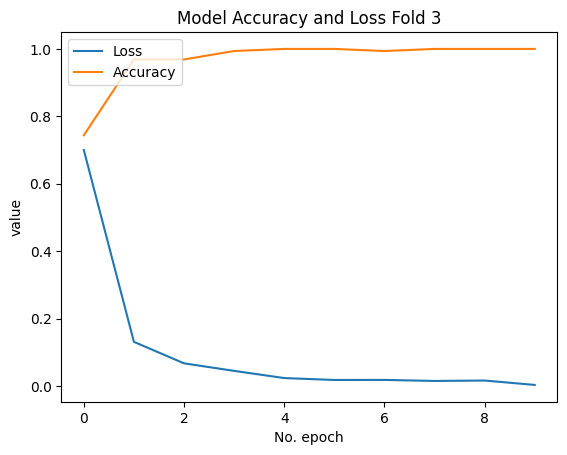



Confusion Matrix untuk fold  3
[[ 8  0  0  2]
 [ 0 10  0  0]
 [ 0  1  9  0]
 [ 0  0  0 10]]


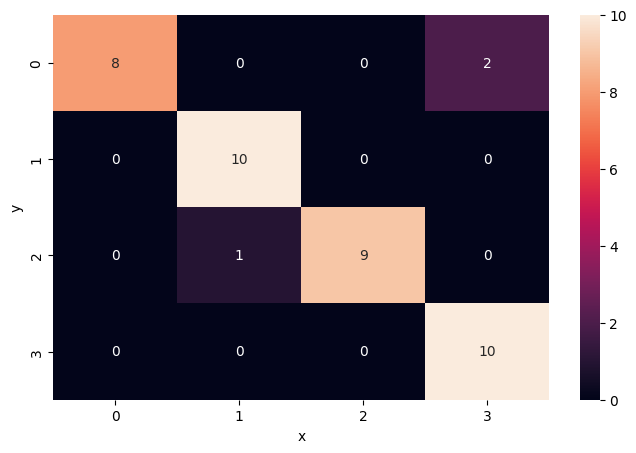

                      precision    recall  f1-score   support

 Culcita novaguineae       1.00      0.80      0.89        10
  Linckia laevigatai       0.91      1.00      0.95        10
    Luidia foliolata       1.00      0.90      0.95        10
Protoreaster nodosus       0.83      1.00      0.91        10

            accuracy                           0.93        40
           macro avg       0.94      0.93      0.92        40
        weighted avg       0.94      0.93      0.92        40

Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 13s 554ms/step - loss: 0.7839 - accuracy: 0.7063 - val_loss: 0.0469 - val_accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 9s 457ms/step - loss: 0.1106 - accuracy: 0.9625 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 7s 357ms/step - loss: 0.0450 - accuracy: 0.9875 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 9s 465ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 7s 353ms/step - loss: 0.0267 - accuracy: 0.9875 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 7s 356ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 9s 465ms/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 8/10
20/20

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 2s 305ms/step - loss: 0.0012 - accuracy: 1.0000
Score for fold 4: loss of 0.001249543740414083; accuracy of 100.0%
5/5 [==============================] - 3s 416ms/step


Cross Validation :  4
Accuracy :  1.0
Precision :  1.0
Recall :  1.0
F1Score :  1.0




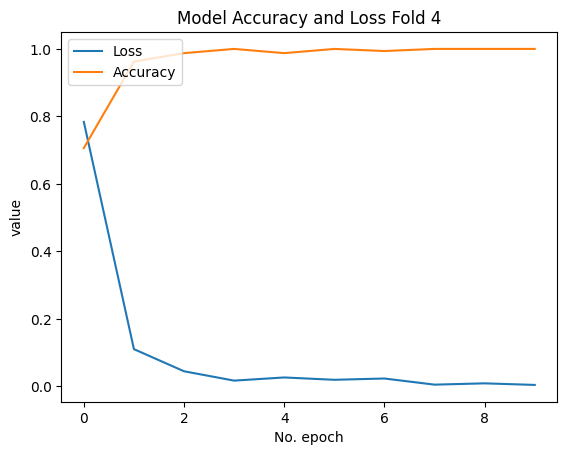



Confusion Matrix untuk fold  4
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


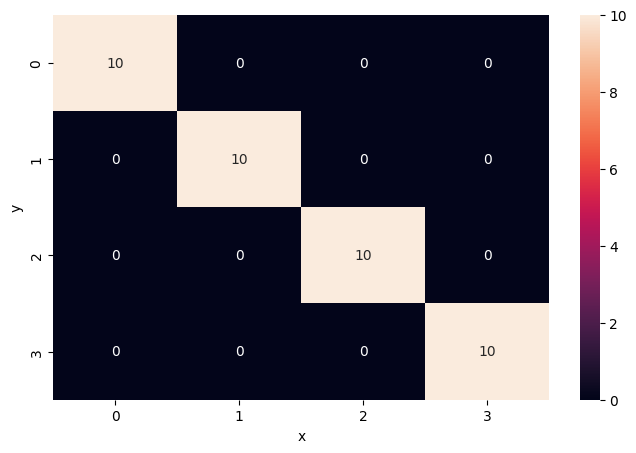

                      precision    recall  f1-score   support

 Culcita novaguineae       1.00      1.00      1.00        10
  Linckia laevigatai       1.00      1.00      1.00        10
    Luidia foliolata       1.00      1.00      1.00        10
Protoreaster nodosus       1.00      1.00      1.00        10

            accuracy                           1.00        40
           macro avg       1.00      1.00      1.00        40
        weighted avg       1.00      1.00      1.00        40

Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 11s 450ms/step - loss: 0.7898 - accuracy: 0.6875 - val_loss: 0.1428 - val_accuracy: 0.9250
Epoch 2/10
20/20 [==============================] - 7s 346ms/step - loss: 0.1122 - accuracy: 0.9688 - val_loss: 0.0317 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 9s 446ms/step - loss: 0.0707 - accuracy: 0.9812 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 7s 343ms/step - loss: 0.0422 - accuracy: 0.9937 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 10s 507ms/step - loss: 0.0380 - accuracy: 0.9812 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 7s 341ms/step - loss: 0.0219 - accuracy: 0.9937 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 7s 335ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 8/10
20/2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model untuk fold 5 telah disimpan. 


5/5 [==============================] - 2s 399ms/step - loss: 0.0060 - accuracy: 1.0000
Score for fold 5: loss of 0.006046950817108154; accuracy of 100.0%
5/5 [==============================] - 2s 252ms/step


Cross Validation :  5
Accuracy :  1.0
Precision :  1.0
Recall :  1.0
F1Score :  1.0




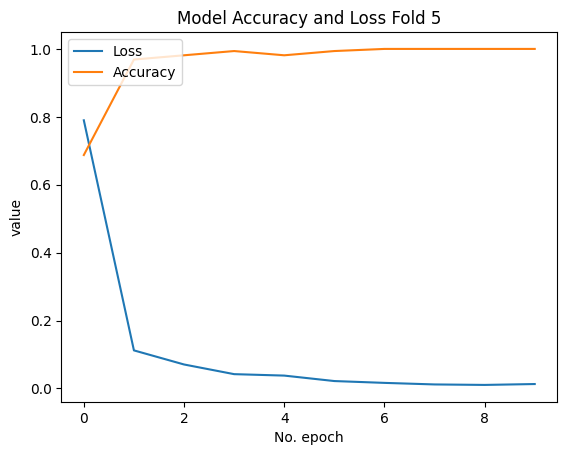



Confusion Matrix untuk fold  5
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


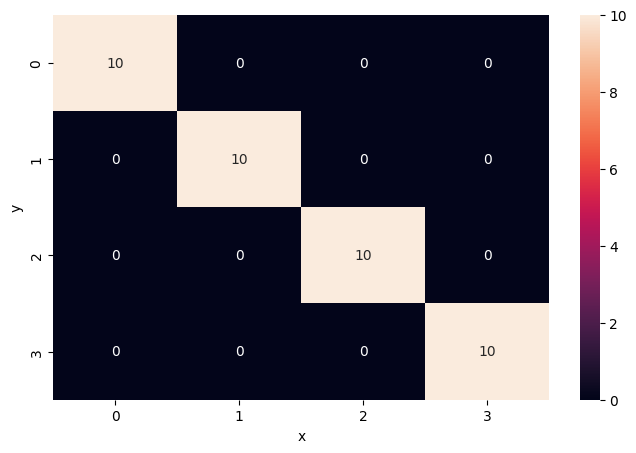

                      precision    recall  f1-score   support

 Culcita novaguineae       1.00      1.00      1.00        10
  Linckia laevigatai       1.00      1.00      1.00        10
    Luidia foliolata       1.00      1.00      1.00        10
Protoreaster nodosus       1.00      1.00      1.00        10

            accuracy                           1.00        40
           macro avg       1.00      1.00      1.00        40
        weighted avg       1.00      1.00      1.00        40



In [ ]:
fold_var = 1

#Looping for each cross validation
for train_index, val_index in kf.split(np.zeros(len(Y)),Y):
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

  train_data_generator = train_datagen.flow_from_dataframe(training_data, directory=image_dir,
                                                           x_col="filename", y_col="label",
                                                           target_size=(224,224),batch_size=8,
                                                           class_mode="categorical", shuffle=True)
  valid_data_generator = test_datagen.flow_from_dataframe(validation_data, directory=image_dir,
                                                           x_col="filename", y_col="label",
                                                           target_size=(224,224),batch_size=8,
                                                           class_mode="categorical", shuffle=False)
  print('\n')

  pretrained_model = MobileNet(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')

  for layer in pretrained_model.layers:
    layer.trainable = False

  #menambahkan layer model
  x = GlobalAveragePooling2D()(pretrained_model.output)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(4, activation='softmax')(x)

  #menggabungkan model
  model = Model(pretrained_model.input, output)

  # compile the model
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'])

  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')
  hist = model.fit(train_data_generator,
                        validation_data=valid_data_generator,
                        epochs = 10,
                        steps_per_epoch=training_data.shape[0] // 8
                        )

  model.save(f"model_fold_{fold_var}.h5")
  print(f"Model untuk fold {fold_var} telah disimpan. ")
  print('\n')

  results = model.evaluate(valid_data_generator)
  #results = model.evaluate( valid_data_generator, batch_size=8, verbose=1, return_dict=False)
  #results = dict(zip(model.metrics_name,results))
  print(f'Score for fold {fold_var}: {model.metrics_names[0]} of {results[0]}; {model.metrics_names[1]} of {results[1]*100}%')

  y_predict = model.predict(valid_data_generator)

  #get the label of validation data
  y = np.asarray(valid_data_generator.labels)

  #Karena output multilabel adalah nilai 0 - 1 dari tiap class maka diambil yang terbesar
  y_predict_labels = np.argmax(y_predict, axis = 1)

  acc = accuracy_score(y_predict_labels, y)
  prec = precision_score(y_predict_labels, y, average = 'weighted')
  rec = recall_score(y_predict_labels, y, average = 'weighted')
  f1score = f1_score(y_predict_labels, y, average = 'weighted')

  print("\n")
  print("Cross Validation : ", fold_var)
  print("Accuracy : ", results[1])
  print("Precision : ", prec)
  print("Recall : ", rec)
  print("F1Score : ", f1score)
  print("\n")

  plt.plot(hist.history['loss'], label='Loss')
  plt.plot(hist.history['accuracy'], label='Accuracy')
  plt.title(f'Model Accuracy and Loss Fold {fold_var}')
  plt.ylabel('value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

  VALIDATION_ACCURACY.append(results[1])
  VALIDATION_PRECISION.append(prec)
  VALIDATION_RECALL.append(rec)
  VALIDATION_F1SCORE.append(f1score)

  LOSS.append(hist.history['loss'])
  ACCURACY.append(hist.history['accuracy'])

  VAL_LOSS.append(hist.history['val_loss'])
  VAL_ACCURACY.append(hist.history['val_accuracy'])

  CV.append("CV" + str(fold_var))

  print("\n")
  print("Confusion Matrix untuk fold ", fold_var)
  print(confusion_matrix(y, y_predict_labels))

  f, axis = plt.subplots(figsize=(8,5))
  sns.heatmap(confusion_matrix(y, y_predict_labels), annot=True, fmt=".0f", ax=axis)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.show()

  target_names =  ['Culcita novaguineae', 'Linckia laevigatai', 'Luidia foliolata', 'Protoreaster nodosus']
  print(classification_report(y, y_predict_labels, target_names=target_names))


  clear_session
  acc_per_fold.append(results[1] * 100)
  loss_per_fold.append(results[0])
  fold_var +=1

In [ ]:
print(VALIDATION_ACCURACY)
print(VALIDATION_PRECISION)
print(VALIDATION_RECALL)
print(VALIDATION_F1SCORE)

[1.0, 0.9750000238418579, 0.925000011920929, 1.0, 1.0]
[1.0, 0.9775, 0.9375, 1.0, 1.0]
[1.0, 0.975, 0.925, 1.0, 1.0]
[1.0, 0.975062656641604, 0.9255677071466545, 1.0, 1.0]


In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} ')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0032338860910385847 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.07237502932548523 - Accuracy: 97.50000238418579%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1133589893579483 - Accuracy: 92.5000011920929%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.001249543740414083 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.006046950817108154 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 98.00000071525574 
> Loss: 0.039252879866398874
------------------------------------------------------------------------


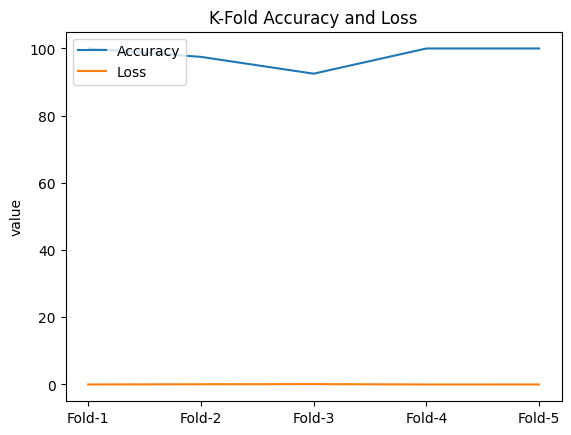

In [ ]:
#ploting k-fold accuracy and loss
from matplotlib import style

plt.plot(acc_per_fold, label='Accuracy')
plt.plot(loss_per_fold, label='Loss')
plt.title('K-Fold Accuracy and Loss')
plt.ylabel('value')
x = ["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"]

default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.legend(loc="upper left")
plt.show()